# Words Clustering

With the embeddings at hand, you can check whether unsupervised Machine Learning methods can arrive at classifications that are comparable to the Roget’s Thesaurus Classification. You can use any clustering method of your choice (experiment freely). You must decide how to measure the agreement between the clusters you find and the classes defined by Roget’s Thesaurus and report your results accordingly. The comparison will be at the class level (six classes) and the section / division level (so there must be two different clusterings, unless you can find good results with hierarchical clustering)


In this file the clustering of the words is performed using the embeddings in both CLASS level and SECTION/DIVISION level and the results are evaluated.

## Importing the necessary libraries

The following libraries are used:
- numpy 
- pandas 
- nomic (for the embeddings)
- KMeans (for the k-means clustering)
- TSNE (for the t-SNE visualization)
- cdist (for the distance calculation)
- classification_report
- matplotlib.pyplot
- linear_sum_assignment (for the Hungarian algorithm)
- silhouette_score
- SpectralClustering (for the spectral clustering)
- KMeansConstrained (for the k-means constrained clustering)
- chromadb (vector database for the storage of the embeddings)

In [1]:
import numpy as np
import pandas as pd
from nomic import embed
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from scipy.spatial.distance import cdist
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import silhouette_score
from sklearn.cluster import SpectralClustering
from k_means_constrained import KMeansConstrained
import chromadb

Loading the words from the `bold_words_with_numbers3.txt` file and applying regex to remove to create a dataframe of the scraped words

In [54]:
# Load the dataframe with a header called word
complete = pd.read_csv('bold_words_with_numbers3.txt', header=None, names=['word'])

#create a dataframe to store the words
df = complete.copy()

#keep only the words that start with #
df = df[df['word'].str.startswith('#')]

#Remove the # and the numbers from the words
df['word'] = df['word'].str.replace(r'#\d+[a-z]?\.\s*', '', regex=True)

#keep only the words that are not empty
df = df[df['word'].str.len() > 0]

#remove any remaining cases
df['word'] = df['word'].str.replace(r'#\d+[a-z]\s+', '', regex=True)

In [55]:
#previewing the words
df

,word
2,Existence
3,Inexistence
4,Substantiality
5,Unsubstantiality
6,Intrinsicality
...,...
1102,Clergy
1103,Laity
1104,Rite
1105,Canonicals


To retrieve the embeddings of the words the nomic library is used.

The Nomic Embedding Library, known as Nomic Embed, is an open-source text embedding model that has been introduced by Nomic AI. This model is notable for its long context length of 8192, which allows it to outperform other models such as OpenAI's Ada-002 and text-embedding-3-small on both short and long context tasks, also, the model weights and training code are released under the Apache-2 license, along with the curated data used for training the model, making it a fully reproducible, open-source option for those looking to work with text embeddings.

[![Example Image](https://blog.nomic.ai/nomic_beats_ada_wide.webp)](https://blog.nomic.ai/posts/nomic-embed-text-v1)

***IMPORTANT NOTE: To use nomic and API key is needed, follow the instructions here to access it [Nomic Atlas](https://atlas.nomic.ai/).***

[Learn more about Nomic Embed](https://blog.nomic.ai/posts/nomic-embed-text-v1).

The embeddings are retrieved using the `embed.text` method from the nomic library. The `model` parameter is set to `nomic-embed-text-v1` and the `task_type` parameter is set to `clustering` for the generation of embeddings catered to clustering.

In [2]:
#retrieve the embeddings from the nomic library
output = embed.text(
    texts=df['word'].tolist(),
    model='nomic-embed-text-v1',
    task_type='clustering'
)

After the embeddings are retrieved, they are stored in a vector database using the `chromadb` library.

**ChromeDB** is an open-source vector database tailored for LLM (Large Language Model) applications. It's designed to efficiently store and query embedding data, extending the capabilities of traditional relational databases to support embeddings. 
 
The `PersistentClient` class is used to create a client that can be used to interact with the vector database. The `create_collection` method is used to create a collection called `nomic_clustering` and the `add` method is used to add the documents, embeddings, metadatas, and ids to the collection.

In [3]:
#Create a client to interact with the vector database
chroma_client = chromadb.PersistentClient("./chromadb")

In [4]:
#delete the collection if needed
#chroma_client.delete_collection(name="nomic_clustering")

In [5]:
#create a collection called nomic_clustering
collection = chroma_client.create_collection(name="nomic_clustering")

In [6]:
#add the documents, embeddings, metadatas, and ids to the collection
collection.add(
    documents=df['word'].tolist(),
    embeddings=output['embeddings'],
    metadatas=[{"word": word} for word in df['word'].tolist()],
    ids=[f"word{i}" for i in range(len(df['word'].tolist()))]
)

In [5]:
#retrieve the collection if needed
collection = chroma_client.get_collection(name="nomic_clustering")

In [6]:
#retrieve the embeddings and the words from the collection
embeddings = collection.get(include=["embeddings", "documents"])['embeddings']
words = collection.get(include=["embeddings", "documents"])['documents']

#create a dataframe with the words and their embeddings
clustering = pd.DataFrame(embeddings)
clustering["words"] = words

#preview the dataframe
clustering

,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,words
0,-0.000912,-0.007648,-0.013954,-0.037872,0.038849,0.065735,-0.023056,0.011604,-0.038788,-0.012558,...,-0.001483,0.029510,-0.023575,0.028534,0.032135,-0.004482,0.024872,-0.033875,0.000118,Existence
1,0.006107,0.040039,-0.014946,-0.024292,0.016998,0.039154,-0.028168,0.035583,-0.014122,-0.033325,...,-0.022247,0.027557,-0.001423,0.002338,0.016632,-0.044891,0.045319,-0.068542,-0.007980,Inexistence
2,0.059204,0.006100,-0.005123,-0.054321,-0.034882,0.018997,-0.005817,0.007236,-0.021179,-0.037292,...,-0.037231,0.053375,0.021027,0.004032,0.052765,-0.002596,0.014313,-0.053986,-0.039551,Consanguinity
3,0.018875,0.013390,-0.010437,-0.059326,-0.019516,0.011765,0.012505,0.021317,-0.027634,-0.009567,...,-0.000041,-0.001012,0.016113,0.040771,-0.008606,0.025223,-0.002115,-0.030319,-0.010986,Trisection
4,0.046478,0.022919,-0.028976,-0.011917,-0.007759,0.053009,0.003397,-0.002504,-0.011650,-0.013397,...,-0.025635,0.038330,-0.017456,0.000619,0.048523,-0.005100,-0.039795,-0.038086,-0.026321,Innocence
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1052,-0.004238,0.026779,-0.016983,-0.037506,-0.036713,-0.006302,-0.063110,0.021225,-0.025635,-0.015961,...,-0.023788,0.029831,-0.020874,-0.014481,0.052826,0.019394,-0.005985,-0.022171,-0.016052,Knave
1053,0.000766,0.026169,-0.018280,-0.051819,-0.020462,0.061768,0.036804,0.017899,-0.024933,-0.060516,...,-0.059875,0.044312,0.017578,0.016464,0.062347,-0.018723,-0.002401,-0.013840,-0.025528,Disinterestedness
1054,0.026566,0.066040,-0.030884,-0.046143,0.011330,0.009888,-0.010605,-0.004765,-0.009094,0.007576,...,-0.012062,0.019012,-0.012985,0.017944,0.031204,-0.006603,-0.002846,-0.034027,-0.018661,Selfishness
1055,0.041321,0.012779,-0.041412,-0.030258,0.006996,0.026581,-0.018646,-0.033325,0.024811,-0.030304,...,0.002119,-0.003220,-0.021271,0.019684,0.043701,0.002037,-0.025024,-0.062561,-0.017624,Virtue


## Clustering on a CLASS level

### K-Means Clustering

For the first clustering attempt on a CLASS level a simple algorithm that can handle large datasets is used, the K-Means Clustering.

The KMeans algorithm clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares. This algorithm requires the number of clusters to be specified. It scales well to large number of samples and has been used across a large range of application areas in many different fields.


We know that there are 6 classes of words, so we set the number of clusters to 6 and perform the k-means clustering.

In [7]:
#perform k-means clustering
kmeans = KMeans(n_clusters=6, random_state=1).fit(clustering.iloc[:, :-1])

For the visualization of the clustering the t-SNE method is used for more precise visualization of the clusters.

***t-SNE (t-distributed Stochastic Neighbor Embedding)*** is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data.

Check out the [t-SNE documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) for more information.

A function is created to visualize the clustering using the t-SNE method. The function takes a dataframe and a list of labels as input and applies t-SNE to reduce dimensionality and plot the t-SNE transformed data with cluster labels as color.

In [8]:
# create a method for the t-SNE visualization that takes a dataframe and a list of labels as input
def visualize_tsne(df, labels):
    """
    Visualizes high-dimensional data using t-SNE (t-Distributed Stochastic Neighbor Embedding) 
    and plots the resulting two-dimensional representation. Each data point in the plot is colored 
    based on its cluster label, providing a visual representation of data clusters in a reduced 
    dimensionality space.

    Parameters:
    df (DataFrame): A pandas DataFrame.
    labels (Array): An array of cluster labels.

    Returns:
    None: This function does not return any value. It generates and displays a scatter plot of the 
          two-dimensional t-SNE representation of the input data, with data points colored according to 
          their cluster labels.
    """
    # Apply t-SNE to reduce dimensionality
    
    #if the dataframe has a small number of rows, use the exact number of rows as the perplexity
    if len(df) < 30:
        tsne = TSNE(n_components=2, random_state=0, perplexity=len(df)-1)
    else:
        tsne = TSNE(n_components=2, random_state=0)
    
    X_tsne = tsne.fit_transform(df)

    # Plot the t-SNE transformed data with cluster labels as color
    plt.figure(figsize=(10, 8))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='Spectral', marker='o', alpha=0.6, edgecolor='w', s=80)
    plt.title('t-SNE visualization of clustering')
    plt.show()


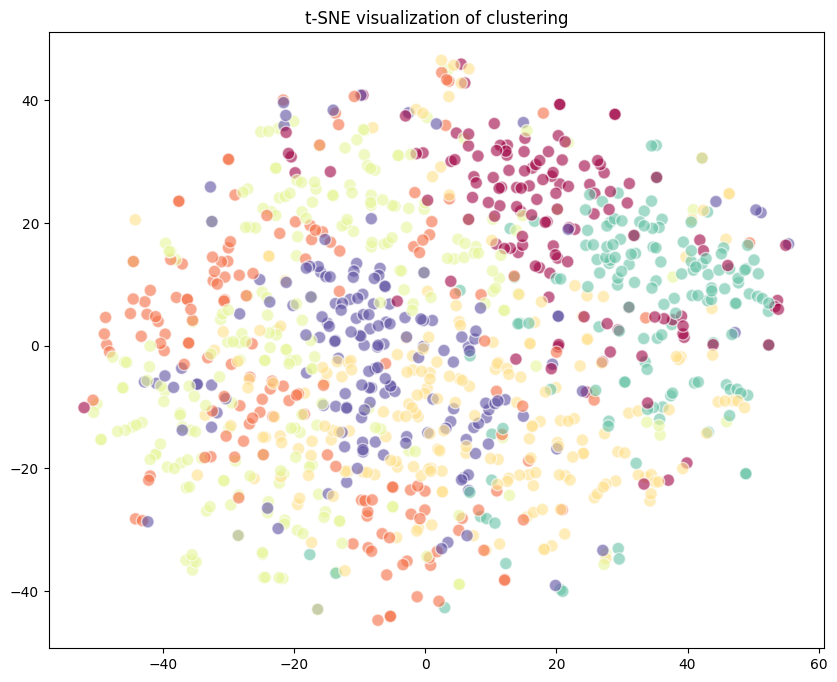

In [9]:
# Visualize the clustering
visualize_tsne(clustering.iloc[:, :-1], kmeans.labels_)

In [10]:
# Getting the cluster assignments for each word
cluster_assignments = kmeans.labels_

# Converting the cluster assignments to a DataFrame
cluster_df = pd.DataFrame({'cluster': cluster_assignments})

In [11]:
# Counting the number of words in each cluster
cluster_counts = cluster_df['cluster'].value_counts().sort_index()

# Print the counts for each cluster
cluster_counts

cluster
0    129
1    158
2    215
3    246
4    145
5    164
Name: count, dtype: int64

In [12]:
# Finding the Centroids of each cluster
centroids = kmeans.cluster_centers_

With the labels and the centroids of the clusters, a function is created to find the closest points of each cluster to each centroid

The function takes the clustering dataframe, the centroids, the cluster assignments, and the top_n parameter as input and calculates the distance from each point to each centroid. It then finds the indices of the top N closest points that are of the same cluster as the centroid and retrieves the word associated with the current index. The function returns a list of lists, where each sublist contains the 'words' from the closest points to each centroid.

This list will be then used to match the clusters to the classes and find the optimal assignment.

In [13]:
def find_closest_points(clustering, centroids, cluster_assignments, top_n=20):
    """
    Find the closest points to each centroid in a clustering setup.

    Parameters:
    - clustering: DataFrame containing the data points and their features.
    - centroids: Array of centroids obtained from a clustering model.
    - cluster_assignments: Array of cluster labels for each data point in clustering.
    - top_n: Number of closest points to find for each centroid (default is 20).

    Returns:
    - clusters_words: A list of lists, where each sublist contains the 'words' from the closest points to each centroid.
    """

    # Calculate the distance from each point to each centroid
    distances = cdist(clustering.iloc[:, :-1], centroids, 'euclidean')

    # Initialize a list to hold the indices of the closest points for each centroid
    closest_points_indices = []

    for i in range(len(centroids)):
        # For each centroid, get the indices of the top N closest points that are of the same cluster as the centroid
        closest_indices = np.argsort(distances[:, i])[cluster_assignments == i][:top_n]
        closest_points_indices.append(closest_indices)

    # Initialize an empty list to store lists of words for each cluster
    clusters_words = []

    # Iterate over each cluster's closest points' indices
    for i, indices in enumerate(closest_points_indices):
        # Initialize an empty list to store words for the current cluster
        cluster_words = []

        print(f"Cluster {i} closest words:")
        # Iterate over the indices of the closest points in the current cluster
        for index in indices:
            # Retrieve the word associated with the current index
            word = clustering.iloc[index, -1]
            # Append the word to the cluster's list of words
            cluster_words.append(word)
            print(word)

        # Append the current cluster's list of words to the main list
        clusters_words.append(cluster_words)
        print()

    return clusters_words


In [14]:
# find the closest points to each centroid
clusters_words = find_closest_points(clustering, centroids, cluster_assignments)

Cluster 0 closest words:
Sharpness
Interiority
Whiteness
Badness
Tenacity
Yellowness
Humility
Impiety
Oldness
Diffuseness
Incompleteness
Inexcitability
Pain
Undueness
Plain
Adversity
Sinistrality
Presence
Truth
Death

Cluster 1 closest words:
Worship
Judgment
Meaning
Friend
Opening
Relation
Power
Payment
Command
Assent
Possession
Substitution
Essay
Prodigy
Teacher
Pursuit
Council
Prisoner
Book
Danger

Cluster 2 closest words:
Avoidance
Rejection
Judgment
Assent
Essay
Conduct
Contempt
Permission
Method
Support
Requirement
Revenge
Opponent
Retaliation
Phrase
Grammar
Departure
Exemption
Insertion
Defiance

Cluster 3 closest words:
Animal
Love
Duty
Space
Enemy
Opponent
Moisture
Memory
Health
Voice
Price
Time
Permission
Change
Traction
Fear
Truth
Command
Direction
Wealth

Cluster 4 closest words:
Inexistence
Duality
Unimportance
Instantaneity
Contiguity
Unsubstantiality
Perpendicularity
Discontinuity
Irresolution
Ingratitude
Unintelligibility
Conciseness
Salubrity
Reasoning
Parsimony
Inferi

Generating the lists of lists needed to be matched to the clusters, the lists are created by splitting the dataframe into 6 lists, split it if a row contains the word "CLASS"

In [15]:
# Create a DataFrame to store the classes and their words
classes_df = complete

# Remove the rows that have the word SECTION or DIVISION
classes_df = classes_df[~classes_df['word'].str.contains('SECTION|DIVISION')]

#create a copy of the dataframe
classes_df = classes_df.copy()

classes_df['word'] = classes_df['word'].str.replace(r'#\d+[a-z]?\.\s*', '', regex=True)
#keep only the words that are not empty
classes_df = classes_df[classes_df['word'].str.len() > 0]

#remove any remaining cases
classes_df['word'] = classes_df['word'].str.replace(r'#\d+[a-z]\s+', '', regex=True)

#split the data frame into 6 lists, split it if a row contains the word "CLASS"
classes = classes_df.groupby(classes_df['word'].str.contains('CLASS').cumsum()).apply(
    lambda x: x['word'].tolist()).tolist()

# remove the first element of each list
classes = [x[1:] for x in classes]

To match the clusters to the lists, the Jaccard similarity is calculated and the optimal assignment is found using the Hungarian algorithm.

***The Jaccard similarity***, also known as the Jaccard index or the Jaccard coefficient, is a statistic used in understanding the similarity and diversity of sample sets. It measures the similarity between finite sets and is defined as the size of the intersection divided by the size of the union of the sets:

$$J(A,B) =\frac{|A∩B|}{|A∪B|}$$

where:
    A and B are two sets.
    ∣A∩B∣ is the number of elements in the intersection of A and B.
    ∣A∪B∣ is the number of elements in the union of A and B.
    
***The Hungarian algorithm***, also known as the Kuhn-Munkres algorithm, is a combinatorial optimization algorithm that solves the assignment problem in polynomial time. The assignment problem involves finding the minimum cost matching in a weighted bipartite graph, where the goal is to match each agent (e.g., Cluster) to a task (e.g., Classe) in such a way that the total cost of all assignments is minimized, and each agent is assigned to exactly one task (assuming the number of agents equals the number of tasks).

The function `match_clusters_to_lists` is created to match clusters to lists containing all the CLASS or SECTION/DIVISION words.

The `linear_sum_assignment` method from the `scipy.optimize` library is used to apply the Hungarian algorithm and find the optimal assignment of clusters to classes.

In [16]:
def match_clusters_to_lists(clusters_words, lists, Word):
    """
    Matches clusters to lists based on Jaccard similarity, finds the optimal assignment using the Hungarian algorithm,
    and prints the matching details.

    Parameters:
    - clusters_words: A list of lists, where each sublist contains words associated with a cluster.
    - lists: A list of lists, where each sublist contains words associated with a class or a division/section.
    - Word: A string indicating the type of the words (e.g., 'Class' or 'Section/Division').
    
    Returns:
    - label_mapping: A dictionary mapping cluster indices to list indices based on the optimal assignment.
    """
    matches = []

    for cluster in clusters_words:
        cluster_matches = [len(set(cluster).intersection(list_)) / len(set(cluster).union(list_)) for list_ in lists]
        matches.append(cluster_matches)

    matches = np.array(matches)
    cost_matrix = 1 - matches  # Convert similarities to costs

    # Apply the Hungarian algorithm
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    label_mapping = dict(zip(row_ind, col_ind))

    # Print the optimal assignment and similarity
    for row, col in zip(row_ind, col_ind):
        print(f"Cluster {row} is best matched with {Word} {col} with a similarity of {matches[row, col]}")

    return label_mapping


In [17]:
# Find the optimal assignment of clusters to classes
label_mapping = match_clusters_to_lists(clusters_words, classes, "Class")

Cluster 0 is best matched with Class 2 with a similarity of 0.031446540880503145
Cluster 1 is best matched with Class 3 with a similarity of 0.02824858757062147
Cluster 2 is best matched with Class 4 with a similarity of 0.04583333333333333
Cluster 3 is best matched with Class 1 with a similarity of 0.0189873417721519
Cluster 4 is best matched with Class 0 with a similarity of 0.034653465346534656
Cluster 5 is best matched with Class 5 with a similarity of 0.0297029702970297


The cluster labels are remapped to the class labels and the classification report is created to evaluate the clustering quality.

In [18]:
# Remap cluster assignments based on a predefined label mapping, if available
remapped_labels = [label_mapping[label] if label in label_mapping else label for label in cluster_assignments]

# Add to the classes_df DataFrame the list number for each word -1
classes_df['class_number'] = classes_df['word'].str.contains('CLASS').cumsum() - 1

# Drop the rows that contain the word "CLASS"
classes_df = classes_df[~classes_df['word'].str.contains('CLASS')]

# Preview the dataframe
classes_df

,word,class_number
2,Existence,0
3,Inexistence,0
4,Substantiality,0
5,Unsubstantiality,0
6,Intrinsicality,0
...,...,...
1102,Clergy,5
1103,Laity,5
1104,Rite,5
1105,Canonicals,5


In [19]:
# Create the classification report
report = classification_report(classes_df['class_number'], remapped_labels)

# Print the classification report
print(report)

              precision    recall  f1-score   support

           0       0.26      0.19      0.22       190
           1       0.12      0.21      0.15       141
           2       0.24      0.22      0.23       144
           3       0.15      0.14      0.14       162
           4       0.35      0.33      0.34       232
           5       0.30      0.26      0.28       188

    accuracy                           0.23      1057
   macro avg       0.24      0.22      0.23      1057
weighted avg       0.25      0.23      0.24      1057


***Discussion of the results***

The classification model demonstrates limited effectiveness with an overall accuracy of 23%. 4 shows the best performance with precision and recall at 0.35 and 0.33, respectively, yet the metrics across all classes indicate a need for improvement. The variation in precision and recall across classes, such as the low precision of 0.12 for Class 1, suggests challenges in consistent prediction. The F1-scores further reflect the model's struggle in achieving a balance between precision and recall. For this reason, more advanced clustering techniques will be explored to improve the model's performance.

### Spectral Clustering

**Spectral clustering** is a method that utilizes the eigenvectors of a graph's Laplacian matrix to perform dimensionality reduction before clustering the data. This technique is effective in identifying complex cluster structures within the data by mapping the data points to a lower-dimensional space where clusters are more distinguishable. The process involves constructing a similarity graph, computing eigenvectors for dimensionality reduction, and then applying a clustering algorithm like k-means to the reduced data.

The `SpectralClustering` method from the `sklearn.cluster` library is used to perform spectral clustering. The number of clusters is set to 6 and the `affinity` parameter is set to 'rbf' to use the Radial Basis Function (RBF) kernel. Also, the `gamma` parameter is set to the best value found through experimentation, and the `assign_labels` parameter is set to 'discretize' to assign labels that are less sensitive to random initialization.

To calculate the best gamma value, Spectral Clustering is performed with different gamma values, assessing the clustering quality through the silhouette score for each gamma. The silhouette score measures how similar an object is to its own cluster compared to other clusters, with a range of [-1, 1]. The silhouette score is calculated for each gamma value, and the best gamma value is selected based on the highest silhouette score.


In [20]:
# Setting the number of clusters 
n_clusters = 6

# Define a range of gamma values to experiment with
gamma_values = np.logspace(-2, 2, num=20)

# Initialize an empty list to store the results
results = []

# Loop over each gamma value to perform Spectral Clustering and evaluate the results
for gamma in gamma_values:
    # Configure the Spectral Clustering algorithm with the current gamma value
    sc = SpectralClustering(n_clusters=n_clusters, affinity='rbf', gamma=gamma, assign_labels='discretize',
                            random_state=1)

    # Perform clustering
    labels = sc.fit_predict(clustering.iloc[:, :-1])

    # Evaluate the clustering quality using silhouette score
    silhouette_avg = silhouette_score(clustering.iloc[:, :-1], labels)

    # Append the results (gamma value and corresponding silhouette score) to the results list
    results.append((gamma, silhouette_avg))

    # Print the gamma value and its corresponding silhouette score for reference
    print(f"Gamma: {gamma}, Silhouette Score: {silhouette_avg}")

    # Stop the loop if the silhouette score becomes negative
    if silhouette_avg < 0:
        print("Stopping the process as the silhouette score has become negative.")
        break

# Extracting the best gamma value and its corresponding silhouette score
best_gamma, best_silhouette = max(results, key=lambda x: x[1])
print(f"Best Gamma: {best_gamma} with Silhouette Score: {best_silhouette}")


Gamma: 0.01, Silhouette Score: 0.014585326420906417
Gamma: 0.016237767391887217, Silhouette Score: 0.014672153166398371
Gamma: 0.026366508987303583, Silhouette Score: 0.014687758773763063
Gamma: 0.04281332398719394, Silhouette Score: 0.01341243305046376
Gamma: 0.06951927961775606, Silhouette Score: 0.01229826466168001
Gamma: 0.11288378916846889, Silhouette Score: 0.013988450681428304
Gamma: 0.18329807108324356, Silhouette Score: 0.014662329866936916
Gamma: 0.29763514416313175, Silhouette Score: 0.012907641946573819
Gamma: 0.4832930238571752, Silhouette Score: 0.014394933985267583
Gamma: 0.7847599703514611, Silhouette Score: 0.014685251418079545
Gamma: 1.2742749857031335, Silhouette Score: 0.014092638987331464
Gamma: 2.06913808111479, Silhouette Score: 0.013914614165591753
Gamma: 3.359818286283781, Silhouette Score: 0.013761475675961218
Gamma: 5.455594781168514, Silhouette Score: 0.013073334380357895
Gamma: 8.858667904100823, Silhouette Score: -0.011046499982065716
Stopping the process 

In [21]:
# Perform Spectral Clustering with the best gamma value
sc = SpectralClustering(n_clusters=n_clusters, affinity='rbf', assign_labels='discretize', random_state=1,
                        gamma=best_gamma)

# Perform clustering
labels = sc.fit_predict(clustering.iloc[:, :-1])

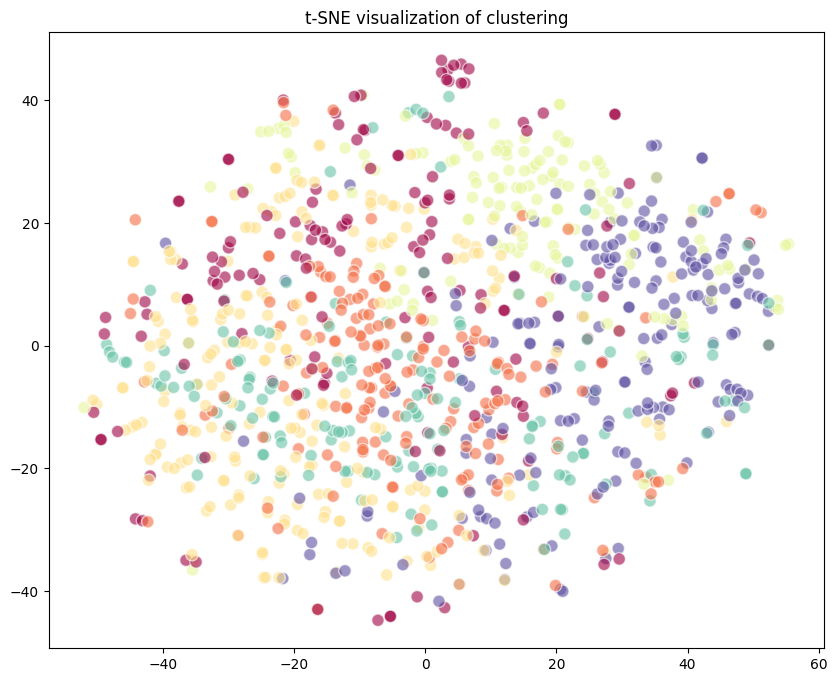

In [22]:
# Visualize the clustering
visualize_tsne(clustering.iloc[:, :-1], labels)

In [23]:
# Get the count of words in each cluster
cluster_counts = pd.Series(labels).value_counts().sort_index()
cluster_counts

0    159
1    179
2    232
3    139
4    160
5    188
Name: count, dtype: int64

Because Spectral Clustering does not have a built-in method to find the centroids, the centroids are calculated as the mean of the points in each cluster.

In [24]:
# Compute centroids as the mean of points in each cluster
centroids = []
for i in range(np.max(labels) + 1):
    cluster_points = clustering.iloc[labels == i, :-1]
    centroid = cluster_points.mean(axis=0)
    centroids.append(centroid)

# Convert the list of centroids to a NumPy array for use with cdist
centroids = np.vstack(centroids)

# Now calculate the distances
distances = cdist(clustering.iloc[:, :-1], centroids, 'euclidean')

Find the closest points to each centroid

In [25]:
# Find the closest points to each centroid
clusters_words = find_closest_points(clustering, centroids, labels)

Cluster 0 closest words:
Word
Virtue
Phrase
Love
Essay
Manifestation
Judgment
Good
Support
Credit
Letter
Killing
Method
Darkness
Duty
Evolution
Inversion
Resistance
Addition
Right

Cluster 1 closest words:
Focus
Respect
Success
Threat
Goodness
Discontent
Action
Substitution
Disclosure
Accusation
Motive
Waste
Discount
Opening
Ambush
Cold
Part
Convergence
Prediction
Time

Cluster 2 closest words:
Form
Zero
Light
Property
Danger
Measurement
Response
Direction
Color
Master
Assent
Utility
Rejection
Avoidance
Demon
Inversion
School
Approach
Stealing
Respect

Cluster 3 closest words:
Interiority
Dryness
Hardness
Tenacity
Laxity
Extraneousness
Dimness
Inexcitability
Pitilessness
Diffuseness
Generality
Attraction
Truth
Conduct
Fastidiousness
Pleasure
Intention
Impurity
Verticality
Term

Cluster 4 closest words:
Resistance
Permission
Obedience
Exclusion
Subjection
Requirement
Reasoning
Rejection
Consent
Submission
Qualification
Avoidance
Meaning
Compulsion
Term
Retention
Willingness
Writing
Unwi

Apply the Hungarian algorithm to find the optimal assignment of clusters to classes

In [26]:
# Find the optimal assignment of clusters to classes
label_mapping = match_clusters_to_lists(clusters_words, classes, "Class")

Cluster 0 is best matched with Class 3 with a similarity of 0.02824858757062147
Cluster 1 is best matched with Class 5 with a similarity of 0.0196078431372549
Cluster 2 is best matched with Class 1 with a similarity of 0.025477707006369428
Cluster 3 is best matched with Class 2 with a similarity of 0.025
Cluster 4 is best matched with Class 4 with a similarity of 0.0546218487394958
Cluster 5 is best matched with Class 0 with a similarity of 0.03980099502487562


In [27]:
# Remap cluster assignments based on a predefined label mapping, if available
remapped_labels_spec = [label_mapping[label] if label in label_mapping else label for label in labels]

# Generate the classification report
report = classification_report(classes_df['class_number'], remapped_labels_spec)

# Print the classification report
print(report)

              precision    recall  f1-score   support

           0       0.24      0.24      0.24       190
           1       0.18      0.29      0.22       141
           2       0.27      0.26      0.26       144
           3       0.21      0.20      0.21       162
           4       0.40      0.28      0.33       232
           5       0.27      0.26      0.27       188

    accuracy                           0.26      1057
   macro avg       0.26      0.26      0.25      1057
weighted avg       0.27      0.26      0.26      1057


***Discussion of the results***

Based on the provided results, the model shows a small improvement in accuracy to 26% from the previous 23%, with a somewhat more stable F1-score distribution across classes, yet still indicating room for enhancement. 4 has the highest F1-score with 0.33 , showing some strengths in specific areas, but the overall performance suggests that further actions are needed to achieve more reliable and consistent classification outcomes. For this reason a final model will be explored , the k-means constrained clustering, to try to improve the model's performance.


### K-Means Constrained Clustering

K-Means Constrained Clustering is an extension of the traditional K-Means algorithm that incorporates additional constraints into the clustering process. These constraints can be in the form of must-link or cannot-link conditions between data points, ensuring certain points end up in the same cluster or different clusters, respectively. This approach is useful for incorporating domain knowledge or specific requirements into the clustering process, potentially leading to more meaningful and useful clusters.

The `KMeansConstrained` method from the `k_means_constrained` library is used to perform k-means constrained clustering. The number of clusters is set to 6, and the `size_min` and `size_max` parameters are set to close to the minimum and maximum cluster sizes, respectively.

It is possible to find the size of each class so that the size_min and size_max parameters can be be defined.

In [28]:
#for each class list, print the length of the list
for i in range(len(classes)):
    print(f"Class {i} has {len(classes[i])} words")

Class 0 has 190 words
Class 1 has 141 words
Class 2 has 144 words
Class 3 has 162 words
Class 4 has 232 words
Class 5 has 188 words


From those results, we can set the size_min and size_max parameters to 135 and 250, respectively and then perform the k-means constrained clustering.

In [29]:
# Initializing the KMeansConstrained model
kmeans_constrained = KMeansConstrained(n_clusters=6, size_min=135, size_max=250, random_state=11234)

# Performing clustering
kmeans_constrained.fit(clustering.iloc[:, :-1])

# Get the cluster assignments
cluster_assignments = kmeans_constrained.labels_

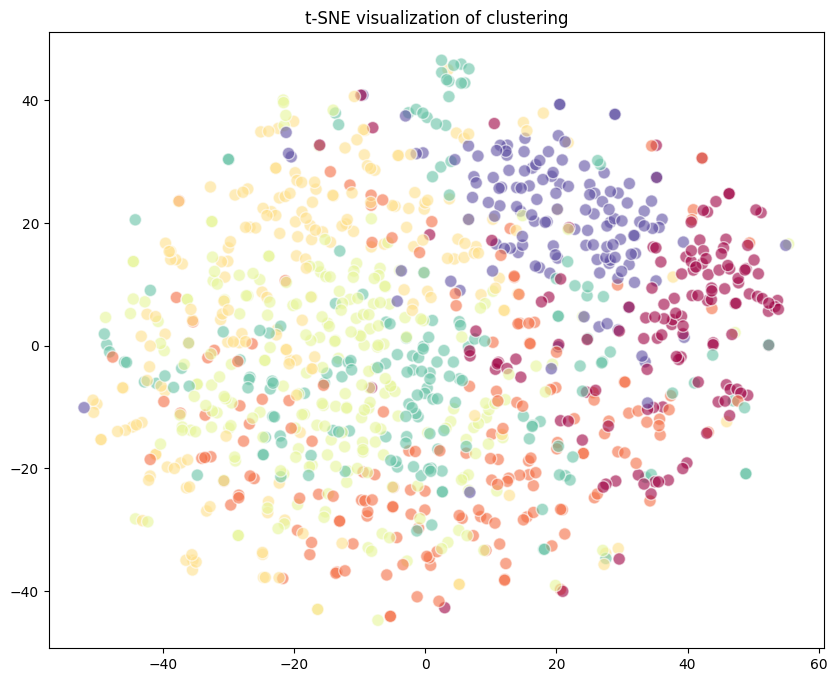

In [30]:
# Visualize the clustering
visualize_tsne(clustering.iloc[:, :-1], cluster_assignments)

In [31]:
# Get the count of words in each cluster
cluster_counts = pd.Series(cluster_assignments).value_counts().sort_index()
cluster_counts

0    135
1    173
2    206
3    232
4    175
5    136
Name: count, dtype: int64

In [32]:
# Find the Centroids of each cluster
centroids = kmeans_constrained.cluster_centers_

After getting the cluster assignments and the centroids, the closest points to each centroid are found.

In [33]:
# Find the closest points to each centroid
clusters_words = find_closest_points(clustering, centroids, cluster_assignments)

Cluster 0 closest words:
Intemperance
Inexpectation
Incredulity
Obliquity
Impotence
Unmeaningness
Inextension
Simpleness
Severity
Perpetuity
Nonuniformity
Disapprobation
Instrumentality
Requirement
Intrinsicality
Neglect
Necessity
Deviation
Greatness
Sibilation

Cluster 1 closest words:
Composition
Convergence
Reproduction
bisection
Relation
Contraction
Part
Requirement
Reward
Submission
Judgment
Reasoning
Attack
Deterioration
Presence
Expectation
Circuit
Correlation
Direction
Similarity

Cluster 2 closest words:
Love
Power
Essay
Touch
Addition
Motion
Space
Duty
Reward
Description
Relation
Wit
Party
Ship
Fashion
Air
Property
Youth
Memory
Answer

Cluster 3 closest words:
Pain
Focus
Answer
Sound
Grammar
Enemy
Stealing
Command
Letter
Snap
Resistance
Wrong
Motion
Restraint
Edge
Part
Forgiveness
Insertion
Goodness
Choice

Cluster 4 closest words:
Duty
Obedience
Virtue
Forgiveness
Contempt
Exclusion
Letter
Support
Permission
Belief
Worship
Meaning
Resentment
Deception
Motive
Avoidance
Good
L

Appling the Hungarian algorithm to find the optimal assignment of clusters to classes

In [34]:
# Find the optimal assignment of clusters to classes
label_mapping = match_clusters_to_lists(clusters_words, classes, "Class")

Cluster 0 is best matched with Class 3 with a similarity of 0.02247191011235955
Cluster 1 is best matched with Class 0 with a similarity of 0.034653465346534656
Cluster 2 is best matched with Class 2 with a similarity of 0.012345679012345678
Cluster 3 is best matched with Class 4 with a similarity of 0.024489795918367346
Cluster 4 is best matched with Class 5 with a similarity of 0.04
Cluster 5 is best matched with Class 1 with a similarity of 0.025477707006369428


In [35]:
# Remap cluster assignments based on a predefined label mapping, if available
remapped_labels_constrained = [label_mapping[label] if label in label_mapping else label for label in
                               cluster_assignments]

# Generate the classification report
report = classification_report(classes_df['class_number'], remapped_labels_constrained)

# Print the classification report and the confusion matrix
print(report)

              precision    recall  f1-score   support

           0       0.21      0.19      0.20       190
           1       0.28      0.27      0.27       141
           2       0.27      0.39      0.32       144
           3       0.33      0.27      0.30       162
           4       0.30      0.30      0.30       232
           5       0.26      0.24      0.25       188

    accuracy                           0.27      1057
   macro avg       0.27      0.28      0.27      1057
weighted avg       0.27      0.27      0.27      1057


In [36]:
#print the confusion matrix
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(classes_df['class_number'], remapped_labels_constrained)

print(cf)

[[36 24 46 22 24 38]
 [40 38 21  6 28  8]
 [24 27 56 15 15  7]
 [15  7 35 44 37 24]
 [45 11 27 26 70 53]
 [13 29 21 22 58 45]]


***Discussion of the results***

The k-means constrained clustering model demonstrates a small improvement of the accuracy to 27% from the previous 26%, with a more balanced F1-score distribution across classes. Because there isn't a significant improvement in the model's performance but it has the highest accuracy so far, so this model will be used to perform the clustering on a SECTION/DIVISION level.

Overall, the results indicate that the k-means constrained clustering model is the most effective of the three models, yet the classification quality remains limited. The variation in precision and recall across classes suggests that the model's performance is inconsistent, and the F1-scores further reflect the model's struggle in achieving a balance between precision and recall. As a result, it is evident that Usupervised Learning techniques are not sufficient to achive Roget Thesarus's classification at a CLASS level, because of the the low accuracy and the complexity of the patterns in the data.

In [37]:
#add to the classes_df the cluster number for each word
classes_df['cluster_number'] = remapped_labels_constrained

#checking the mapping of the clusters to the classes
classes_df

,word,class_number,cluster_number
2,Existence,0,1
3,Inexistence,0,3
4,Substantiality,0,0
5,Unsubstantiality,0,0
6,Intrinsicality,0,5
...,...,...,...
1102,Clergy,5,4
1103,Laity,5,3
1104,Rite,5,5
1105,Canonicals,5,5


Now we will keep only the words that have the correct cluster-to-class, this will be helpful c late

In [38]:
# Define the correct cluster-to-class mappings
correct_mappings = {1: 0, 2: 2, 3: 4, 4: 5, 5: 1}

# Filter the DataFrame to keep only rows where the cluster-to-class mapping is correct
filtered_df = classes_df.loc[classes_df['cluster_number'].map(correct_mappings) == classes_df['class_number']]

# 'filtered_df' now contains only the words with correct cluster-to-class mappings
filtered_df

,word,class_number,cluster_number
2,Existence,0,1
22,Imitation,0,1
60,Completeness,0,1
76,Beginning,0,1
80,Discontinuity,0,1
...,...,...,...
1081,Deity,5,4
1088,Theology,5,4
1095,Irreligion,5,4
1097,Idolatry,5,4


In [39]:
#find the counts of the correct mappings
filtered_df['class_number'].value_counts()

class_number
5    58
2    56
4    26
0    24
1     8
Name: count, dtype: int64

## Clustering on a SECTION/DIVISION level

So there are to ways to go about this, the first one is to perform the clustering on a SECTION/DIVISION level, with the original CLASS level, and the second one is to perform the clustering on a SECTION/DIVISION level, using only the correct words after the remapping of the clusters to the classes

We will try both ways.

### Clustering on a SECTION/DIVISION level, with the original CLASS level

Το perform the clustering on a SECTION/DIVISION level with the original CLASS level, firstly we need to know the number of sections and divisions in each class. To do that we will count them, the counts are based result on the second hierarchical level of the `bold_words_with_numbers3.txt` .

In [40]:
# Create a list to store the counts
counts = []

# Initialize a counter
count = 0

# Initialize a variable to keep track of what to count ('SECTION' or 'DIVISION')
count_what = None

# Iterate over each row in the DataFrame
for index, row in complete.iterrows():
    # Check if the row contains the word 'CLASS'
    if 'CLASS' in row['word']:
        # Append the current count to the list if it's greater than 0
        if count > 0:
            counts.append(count)
        # Reset the counter and the count_what variable
        count = 0
        count_what = None
    else:
        # Determine what to count based on the first occurrence of 'SECTION' or 'DIVISION'
        if count_what is None:
            if 'SECTION' in row['word']:
                count_what = 'SECTION'
            elif 'DIVISION' in row['word']:
                count_what = 'DIVISION'

        # Increment the counter based on the count_what setting
        if count_what == 'SECTION' and 'SECTION' in row['word']:
            count += 1
        elif count_what == 'DIVISION' and 'DIVISION' in row['word']:
            count += 1

# Append the last count to the list if it's greater than 0
if count > 0:
    counts.append(count)

# Display the counts
counts

[8, 4, 3, 2, 2, 5]

Now that we have the number of sections or divisions for each class, a 2D list is created to store all the words of the sections/divisions.

This below code processes a DataFrame to remove specific rows based on the presence of 'SECTION' in classes that contain 'DIVISION', and also drops rows with 'CLASS'. It iterates through the DataFrame, tracking when it enters a class with a division, and marks 'SECTION' rows for removal in such cases. Finally, it splits the DataFrame into lists at 'SECTION' or 'DIVISION' rows and returns a list of lists, each representing a section or division.

In [41]:
# Create a copy of the DataFrame to preserve the original
sections_divisions = complete.copy()

# Clean up the 'word' column
sections_divisions['word'] = sections_divisions['word'].str.replace(r'#\d+[a-z]?\.\s*', '', regex=True)
sections_divisions['word'] = sections_divisions['word'].str.replace(r'#\d+[a-z]\s+', '', regex=True)

# Keep only the rows where 'word' is not empty
sections_divisions = sections_divisions[sections_divisions['word'].str.len() > 0]

# Initialize variables to track the state
in_class_with_division = False  # Whether we are in a class that contains a division
rows_to_drop = []  # Rows to drop because they contain 'SECTION' in a class with 'DIVISION'

# Iterate over the DataFrame
for index, row in sections_divisions.iterrows():
    word = row['word']
    if 'CLASS' in word:
        # We've encountered a new class, so reset our flag
        in_class_with_division = False
    elif 'DIVISION' in word:
        # We've encountered a 'DIVISION' within a class, so set the flag
        in_class_with_division = True
    elif 'SECTION' in word and in_class_with_division:
        # We're in a class that has a 'DIVISION' and we've encountered a 'SECTION', so mark this row for removal
        rows_to_drop.append(index)

# Drop the marked rows
sections_divisions = sections_divisions.drop(rows_to_drop)

#drop the rows that contain the word "CLASS"
sections_divisions = sections_divisions[~sections_divisions['word'].str.contains('CLASS')]

#split the data frame into lists, split it if a row contains the word "SECTION" or "DIVISION"
sections_divisions = sections_divisions.groupby(
    sections_divisions['word'].str.contains('SECTION|DIVISION').cumsum()).apply(
    lambda x: x['word'].tolist()).tolist()

# remove the first element of each list
sections_divisions = [x[1:] for x in sections_divisions]

Then a dataframe is created containing the embeddings of the words, the words and the class number 

In [42]:
clustering_with_sections_divisions = clustering.copy()

# drop the duplicates
clustering_with_sections_divisions = clustering_with_sections_divisions.drop_duplicates(subset='words')

# merge the class_df with the clustering_with_sections_divisions

clustering_with_sections_divisions = clustering_with_sections_divisions.merge(classes_df, left_on='words',
                                                                              right_on='word')

#drop the word column
clustering_with_sections_divisions = clustering_with_sections_divisions.drop(columns=['word'])

# print all the columns except the last 3
clustering_with_sections_divisions

,0,1,2,3,4,5,6,7,8,9,...,761,762,763,764,765,766,767,words,class_number,cluster_number
0,-0.000912,-0.007648,-0.013954,-0.037872,0.038849,0.065735,-0.023056,0.011604,-0.038788,-0.012558,...,-0.023575,0.028534,0.032135,-0.004482,0.024872,-0.033875,0.000118,Existence,0,1
1,0.006107,0.040039,-0.014946,-0.024292,0.016998,0.039154,-0.028168,0.035583,-0.014122,-0.033325,...,-0.001423,0.002338,0.016632,-0.044891,0.045319,-0.068542,-0.007980,Inexistence,0,3
2,0.059204,0.006100,-0.005123,-0.054321,-0.034882,0.018997,-0.005817,0.007236,-0.021179,-0.037292,...,0.021027,0.004032,0.052765,-0.002596,0.014313,-0.053986,-0.039551,Consanguinity,0,5
3,0.018875,0.013390,-0.010437,-0.059326,-0.019516,0.011765,0.012505,0.021317,-0.027634,-0.009567,...,0.016113,0.040771,-0.008606,0.025223,-0.002115,-0.030319,-0.010986,Trisection,0,2
4,0.046478,0.022919,-0.028976,-0.011917,-0.007759,0.053009,0.003397,-0.002504,-0.011650,-0.013397,...,-0.017456,0.000619,0.048523,-0.005100,-0.039795,-0.038086,-0.026321,Innocence,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1052,-0.004238,0.026779,-0.016983,-0.037506,-0.036713,-0.006302,-0.063110,0.021225,-0.025635,-0.015961,...,-0.020874,-0.014481,0.052826,0.019394,-0.005985,-0.022171,-0.016052,Knave,5,5
1053,0.000766,0.026169,-0.018280,-0.051819,-0.020462,0.061768,0.036804,0.017899,-0.024933,-0.060516,...,0.017578,0.016464,0.062347,-0.018723,-0.002401,-0.013840,-0.025528,Disinterestedness,5,5
1054,0.026566,0.066040,-0.030884,-0.046143,0.011330,0.009888,-0.010605,-0.004765,-0.009094,0.007576,...,-0.012985,0.017944,0.031204,-0.006603,-0.002846,-0.034027,-0.018661,Selfishness,5,5
1055,0.041321,0.012779,-0.041412,-0.030258,0.006996,0.026581,-0.018646,-0.033325,0.024811,-0.030304,...,-0.021271,0.019684,0.043701,0.002037,-0.025024,-0.062561,-0.017624,Virtue,5,3


The below code is used to perform the k-means constrained clustering on a SECTION/DIVISION level iteratively. Within the loop that runs until the list **sections_divisions** is emptied, it processes n sublists at a time, extracting all words, retrieving their embeddings from a predefined DataFrame, and preparing a combined DataFrame of words and embeddings. The code then calculates the minimum and maximum sublist lengths to set constraints for a constrained K-Means clustering, which is performed on the word embeddings ensuring each cluster's size falls within these bounds. Post-clustering, it visualizes the clusters, identifies the closest words to each cluster's centroid, and maps the clusters to original sections or divisions to remap cluster labels to section/division labels. A classification report is generated to evaluate the clustering's performance in classifying words into the correct sections or divisions. Finally, the processed sublists are removed from sections_divisions, and the counter i is incremented, proceeding to the next set of sublists until the list is empty, dynamically adjusting the process to the size of the sections_divisions list. 

(**NOTE**: To rerun the below snippet, rerun the previous 3 code sections to reinitialize the variables and lists.)

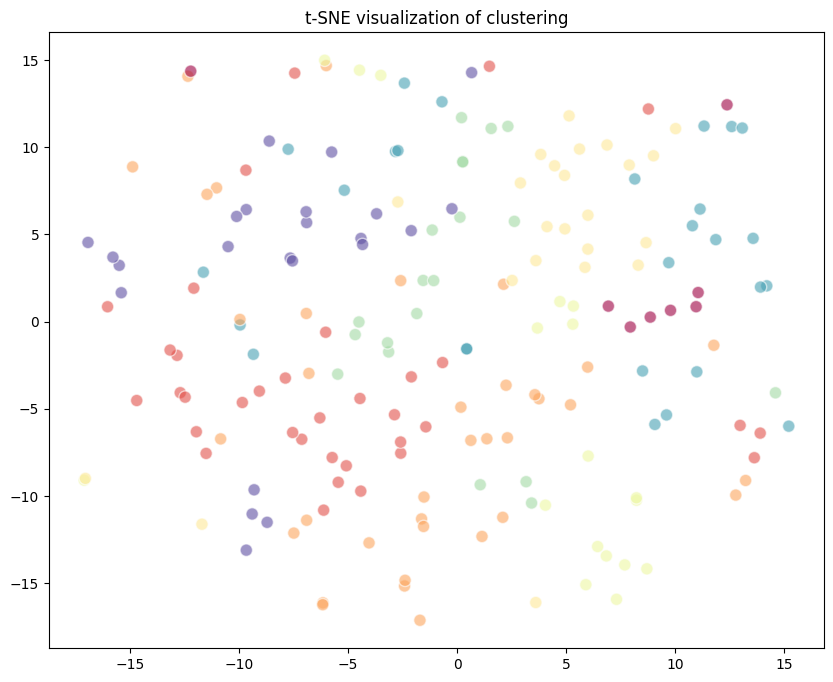

Cluster 0 closest words:
Inexistence
Nonimitation
Continuity
Conformity
Revolution
The Present Time
Arrangement
List

Cluster 1 closest words:
Mixture
Substitution
Decomposition
Arrangement
Irrelation
Inclusion
Focus
Agreement
Duality
Exclusion

Cluster 2 closest words:
Course
Precedence
Youth
Similarity
Substitution
Time
Quantity
Chance
Tendency
Paternity

Cluster 3 closest words:
Unconformity
Instantaneity
Normality
Generality
Discontinuity
Speciality
Triality
Composition
Inequality
Contingent Duration

Cluster 4 closest words:
Infrequency
Decomposition
Moderation
Producer
Speciality
Multitude
Posteriority
Fraction
Numeration
Remainder

Cluster 5 closest words:
Increase
Duality
Tendency
Similarity
Inclusion
Generality
Circumstance
Conformity
Substantiality
Effect

Cluster 6 closest words:
Conformity
Addition
bisection
Triplication
Accompaniment
Composition
Dissimilarity
Focus
Substantiality
Remainder

Cluster 7 closest words:
Plurality
Periodicity
Conversion
Occasion
Correlation
Prec

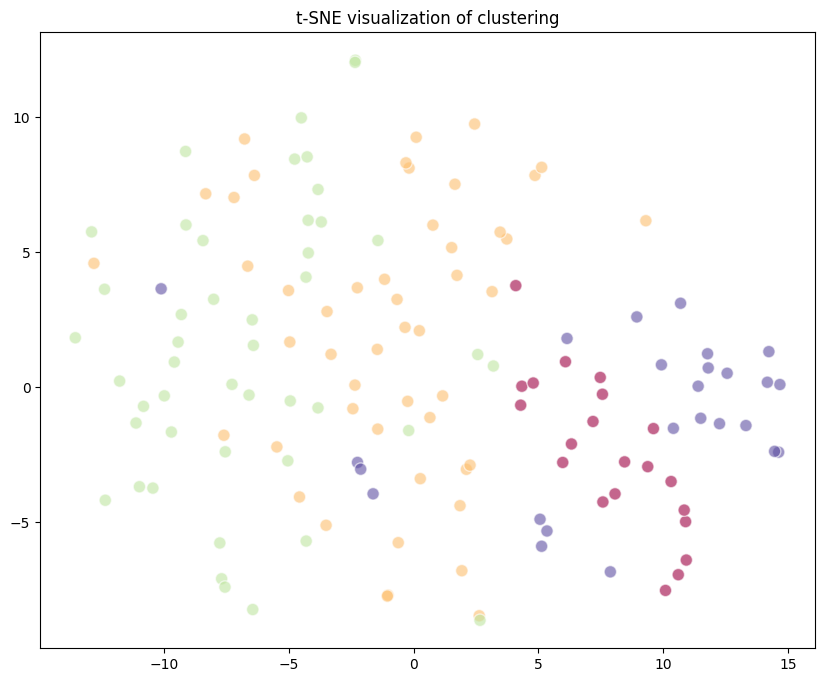

Cluster 0 closest words:
Length
Height
Size
Distance
Verticality
Perpendicularity
Interiority
Horizontality
Laterality
Angularity

Cluster 1 closest words:
Departure
Convergence
Extraction
Deviation
Motion
Direction
Crossing
Evolution
Transference
Summit

Cluster 2 closest words:
Motion
Edge
Ship
Layer
Traction
Insertion
Crossing
Fold
Depth
Situation

Cluster 3 closest words:
Concavity
Distortion
Precession
Nearness
Littleness
Sharpness
Transcursion
Displacement
Shallowness
Thinness

Cluster 0 is best matched with Section/Division 1 with a similarity of 0.17307692307692307
Cluster 1 is best matched with Section/Division 3 with a similarity of 0.14814814814814814
Cluster 2 is best matched with Section/Division 0 with a similarity of 0.045454545454545456
Cluster 3 is best matched with Section/Division 2 with a similarity of 0.09375
              precision    recall  f1-score   support

           0       0.15      0.54      0.24        13
           1       0.62      0.25      0.36      

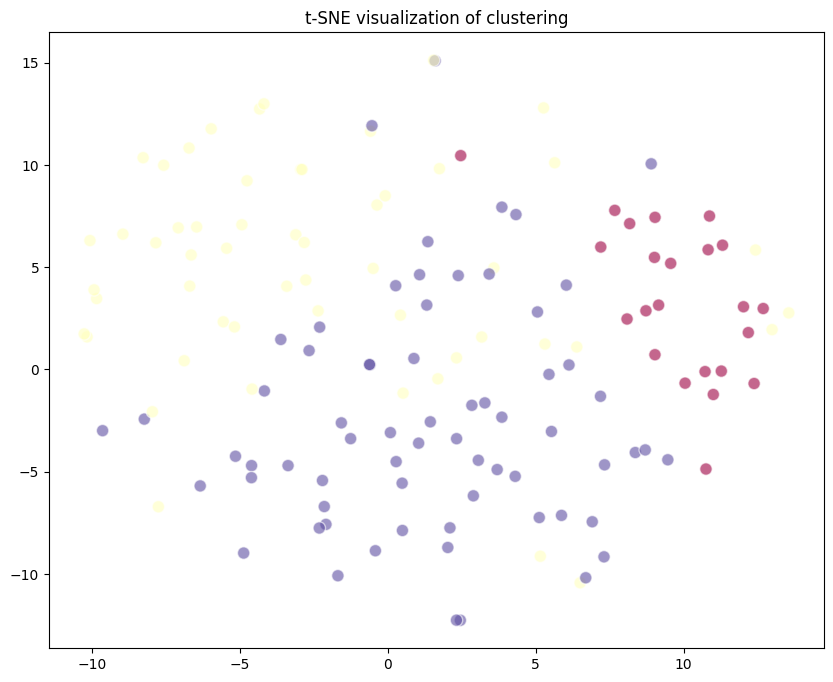

Cluster 0 closest words:
Nonresonance
Musician
River
Marsh
Sensations of Touch
Melody
Inelasticity
Lubrication
Insipidity
Agriculture

Cluster 1 closest words:
Fluidity
Dryness
Sourness
Tenacity
Materiality
Elasticity
Numbness
Water
Greenness
Immateriality

Cluster 2 closest words:
Animal
Music
Air
Odor
River
Life
Vegetable
Cry
Hearing
Ocean

Cluster 0 is best matched with Section/Division 1 with a similarity of 0.09090909090909091
Cluster 1 is best matched with Section/Division 0 with a similarity of 0.15384615384615385
Cluster 2 is best matched with Section/Division 2 with a similarity of 0.0673076923076923
              precision    recall  f1-score   support

           0       0.06      0.60      0.10         5
           1       0.00      0.00      0.00        38
           2       0.69      0.46      0.55       101

    accuracy                           0.34       144
   macro avg       0.25      0.35      0.22       144
weighted avg       0.48      0.34      0.39       144


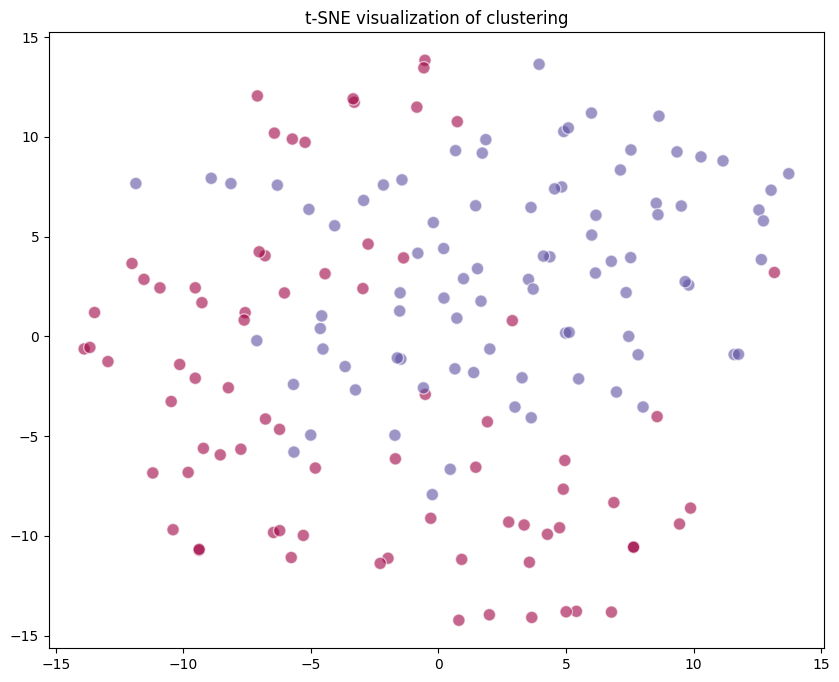

Cluster 0 closest words:
Deception
Belief
Truth
Incredulity
Incuriosity
Inexpectation
Meaning
Misrepresentation
Incomparability
Unintelligibility

Cluster 1 closest words:
Grammar
Book
Letter
Speech
Correspondence
Response
Answer
Language
Judgment
Assent

Cluster 0 is best matched with Section/Division 0 with a similarity of 0.075
Cluster 1 is best matched with Section/Division 1 with a similarity of 0.07865168539325842
              precision    recall  f1-score   support

           0       0.55      0.55      0.55        76
           1       0.60      0.60      0.60        86

    accuracy                           0.58       162
   macro avg       0.58      0.58      0.58       162
weighted avg       0.58      0.58      0.58       162


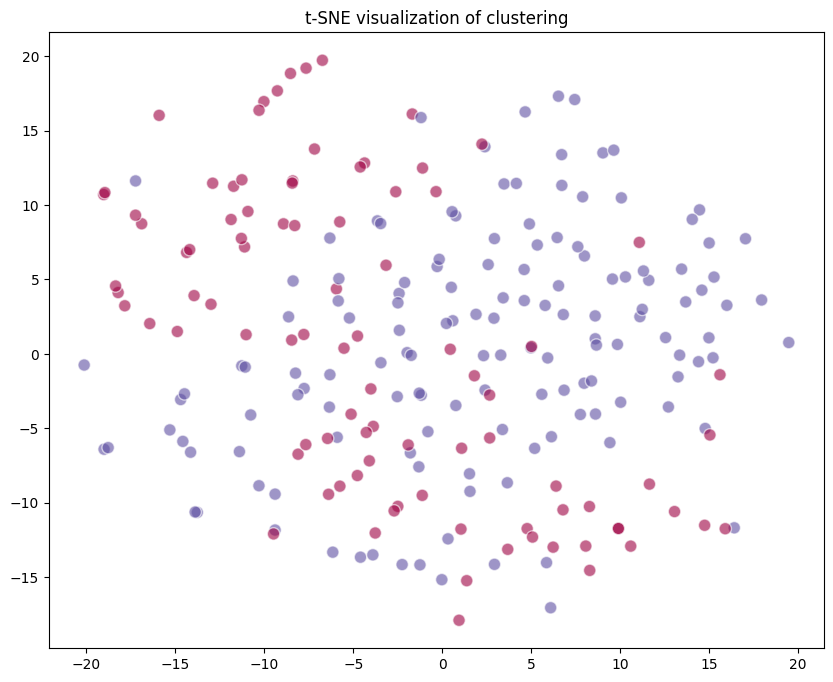

Cluster 0 closest words:
Inaction
Refusal
Irresolution
Failure
Restraint
Retention
Requirement
Insufficiency
Subjection
Obedience

Cluster 1 closest words:
Credit
Good
Possession
Opponent
Value
Action
Essay
Means
Submission
Borrowing

Cluster 0 is best matched with Section/Division 1 with a similarity of 0.05154639175257732
Cluster 1 is best matched with Section/Division 0 with a similarity of 0.041666666666666664
              precision    recall  f1-score   support

           0       0.55      0.55      0.55       141
           1       0.30      0.31      0.31        91

    accuracy                           0.45       232
   macro avg       0.43      0.43      0.43       232
weighted avg       0.45      0.45      0.45       232


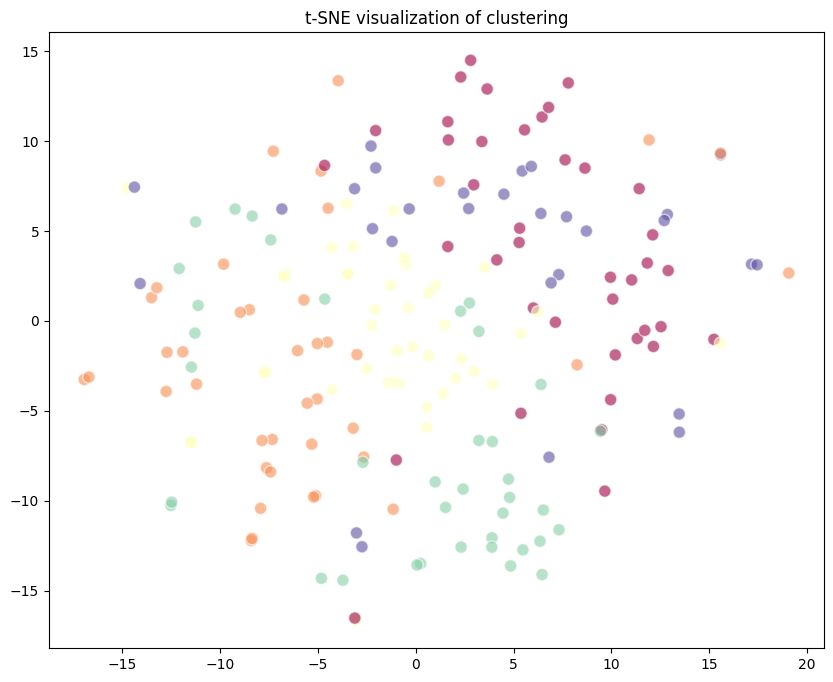

Cluster 0 closest words:
Ingratitude
Indifference
Insensibility
Painfulness
Hopelessness
Probity
Discourtesy
Virtue
Duty
Feeling

Cluster 1 closest words:
Exclusion
Punishment
Hell
Exemption
Hope
Caution
Wonder
Angel
Heaven
Prodigy

Cluster 2 closest words:
Respect
Resentment
Reward
Friend
Celebration
Hope
Envy
Endearment
Expectance
Enemy

Cluster 3 closest words:
Punishment
Friend
Courage
Accusation
Servility
Jealousy
Friendship
Prodigy
Taste
Gratitude

Cluster 4 closest words:
Desire
Love
Feeling
Affectation
Fashion
Vulgarity
Rashness
Duty
Painfulness
Worship

Cluster 0 is best matched with Section/Division 0 with a similarity of 0.13333333333333333
Cluster 1 is best matched with Section/Division 4 with a similarity of 0.09090909090909091
Cluster 2 is best matched with Section/Division 2 with a similarity of 0.11904761904761904
Cluster 3 is best matched with Section/Division 3 with a similarity of 0.03125
Cluster 4 is best matched with Section/Division 1 with a similarity of 0.090909

In [43]:
#initialize i to keep track of the number of the class we are in
i=0
#loop until the section_division list is empty
while len(sections_divisions) > 0:
    n=counts[i]
    #get the first n lists of sections and divisions
    words = []
    if 0 < n <= len(sections_divisions):
        for sublist in sections_divisions[:n]:
            words.extend(sublist)  # Add words from each sublist to the main list
    
    # Create a DataFrame to store the words
    words_for_clust = pd.DataFrame(words, columns=['words'])
    
    # Merge the words with the embeddings
    embeddings_list = words_for_clust['words'].apply(
    lambda x: clustering_with_sections_divisions[clustering_with_sections_divisions['words'] == x].iloc[0,
              :-1].tolist()).tolist()

    #Convert the list of lists into a DataFrame
    embeddings_df = pd.DataFrame(embeddings_list)
    
    #Concatenate the new DataFrame of embeddings with the 'words' column
    words_for_clust = pd.concat([embeddings_df, words_for_clust[['words']]], axis=1)
    
    #drop the column 768 and 769 that are duplicates from the merging
    words_for_clust = words_for_clust.drop(columns=[768, 769])
    
    #find the minimum number and maximum length in the fist n lists of sections and divisions
    min_length = float('inf')  # Set min_length to infinity initially
    max_length = 0  # Set max_length to 0 initially
    
    # Iterate over the first 'n' lists in 'sections_divisions'
    for sublist in sections_divisions[:n]:
        # Update min_length and max_length based on the length of the current sublist
        sublist_length = len(sublist)
        if sublist_length < min_length:
            min_length = sublist_length
        if sublist_length > max_length:
            max_length = sublist_length
    
    # Check if any lists were processed and update min_length if not
    if min_length == float('inf'):
        min_length = 0  # If no lists were processed, set min_length to 0
    
    # perform k-means clustering restricted 
    kmeans_constrained = KMeansConstrained(n_clusters=n, size_min=min_length, size_max=max_length, random_state=11234)
    
    # Perform clustering
    kmeans_constrained.fit(words_for_clust.iloc[:, :-1])
    
    # get the cluster labels
    cluster_assignments = kmeans_constrained.labels_
    
    # Visualize the clustering
    visualize_tsne(words_for_clust.iloc[:, :-1], cluster_assignments)
    
    # Find the Centroids of each cluster
    centroids = kmeans_constrained.cluster_centers_
    
    # Find the closest points to each centroid
    clusters_words = find_closest_points(words_for_clust, centroids, cluster_assignments, top_n=10)
    
    # Find the optimal assignment of clusters to classes
    label_mapping = match_clusters_to_lists(clusters_words, sections_divisions[:n], "Section/Division")
    
    # Remap cluster assignments based on a predefined label mapping, if available
    
    remapped_labels_constrained = [label_mapping[label] if label in label_mapping else label for label in
                                   cluster_assignments]
    
    #Add to the words_for_clust the section/division number for each word, by checking in which of the n lists the word is
    words_for_clust['section_division_number'] = words_for_clust['words'].apply(
        lambda x: next((i for i, sublist in enumerate(sections_divisions[:n]) if x in sublist), None))
    
    
    # Create the classifiaction report
    report = classification_report(words_for_clust['section_division_number'], remapped_labels_constrained)
    
    print(report)
    
    #remove the first n lists of sections and divisions
    sections_divisions = sections_divisions[n:]
    
    #increment i
    i += 1


***Discussion of the results***

Analyzing the classification reports for the sections/divisions of each class,reveals a wide range of prediction performances, with overall accuracies stretching from a low of 22% to a high of 58%. It is evident that the k-means constrained clustering model was more effective categorizing words into divisions than sections and that's because the two categorization performed in classes that have DIVISIONS, (Class 4 and 5) have an accuracy of 45% and 58% respectively, while the categorization performed in classes that have SECTIONS, (Class 1, 2, 3, 6) have an accuracy of 22%, 44%, 34% and 27%. This can be explained because the divisions split the classes into fewer segments than the sections, so the model has fewer segments to predict. 

Overall, even though in a SECTION/DIVISION level the k-means constrained clustering model was more effective than in a CLASS level, the classification quality remains limited, with the lowest accuracy being 22% and the highest 58%. The variation in accuracy across classes suggests that the model's performance is inconsistent, and the F1-scores further reflect the model's struggle in achieving a balance between precision and recall. As a result, it is evident that Usupervised Learning techniques are not sufficient to achive Roget Thesarus's classification at a SECTION/DIVISION level, because of the the low accuracy and the complexity of the patterns in the data.

### Clustering on a SECTION/DIVISION level, with only the correct words after the remapping of the clusters to the classes

To perform the clustering on a SECTION/DIVISION level with only the correct words after the remapping of the clusters to the classes, first we need to create a dataframe that contains the correct words after the remapping of the clusters to the classes as lists

In [44]:
sections_divisions_2 = pd.DataFrame({'words': ['cluster0', 'cluster1', 'cluster2', 'cluster3', 'cluster4', 'cluster5']})

for i in range(6):
    # Retrieve words belonging to the current cluster from the filtered DataFrame
    words_in_cluster = filtered_df[filtered_df['cluster_number'] == i]['word'].tolist()
    
    # Update the 'words' column in 'sections_divisions_2' for the current cluster with the list of retrieved words
    sections_divisions_2.at[i, 'words'] = words_in_cluster  # Assign the list directly

sections_divisions_2 = sections_divisions_2.reindex([1, 5, 2, 0, 3, 4]).reset_index(drop=True)

sections_divisions_2

,words
0,"[Existence, Imitation, Completeness, Beginning..."
1,"[Verticality, Angularity, Bluntness, Furrow, O..."
2,"[Softness, Elasticity, Inelasticity, Brittlene..."
3,[]
4,"[Pursuit, Avoidance, Instrument, Relapse, Bane..."
5,"[Sensibility, Insensibility, Excitation, Inexc..."


Then we need to find the SECTIONS/DIVISIONS number for each word

The below function `process_sec_div` processes a DataFrame by iterating through each row to manage counters related to sections and divisions within a document. Initially, it looks for 'CLASS' in the 'word' column to start a new count. When a 'CLASS' is found, it resets the section/division counter and starts looking for 'SECTION'. If 'SECTION' or 'DIVISION' is found, it increments the counter. Finding a 'DIVISION' changes the focus solely to 'DIVISION' until the next 'CLASS' is encountered. It assigns these counters to a new column 'sec_div' and finally and removes rows containing 'CLASS', 'SECTION', or 'DIVISION' keywords, returning the cleaned DataFrame.

In [45]:
def process_sec_div(df):
    sec_div_counter = 0
    looking_for = 'CLASS'  # Start by looking for 'CLASS'

    for index, row in df.iterrows():
        word = row['word']

        # Check for 'CLASS' and increment class counter
        if 'CLASS' in word:
            sec_div_counter = 0  # Reset section/division counter
            looking_for = 'SECTION'  # Start looking for 'SECTION' by default

        # Check for 'SECTION' or 'DIVISION' and increment section/division counter
        elif looking_for == 'SECTION' and 'SECTION' in word or 'DIVISION' in word:
            sec_div_counter += 1
            # If 'DIVISION' is found, only look for 'DIVISION' until the next 'CLASS'
            if 'DIVISION' in word:
                looking_for = 'DIVISION'

        # Assign class counter and section/division counter to the current row
        df.at[index, 'sec_div'] = sec_div_counter
        
    df = df[~df['word'].str.contains('CLASS|SECTION|DIVISION')]
    
    return df

Then we create a dataframe to store the words and the section/division number

In [46]:
# Load the word with the hierarchy from the csv file
complete = pd.read_csv('bold_words_with_numbers3.txt', header=None, names=['word'])

# Create a dataframe to store the words
true_sec_div = complete.copy()

# Remove the # and the numbers from the words
true_sec_div['word'] = true_sec_div['word'].str.replace(r'#\d+[a-z]?\.\s*', '', regex=True)

#keep only the words that are not empty
true_sec_div = true_sec_div[true_sec_div['word'].str.len() > 0]

#remove any remaining cases
true_sec_div['word'] = true_sec_div['word'].str.replace(r'#\d+[a-z]\s+', '', regex=True)

true_sec_div['sec_div'] = 0

true_sec_div = process_sec_div(true_sec_div)

true_sec_div['sec_div'] = true_sec_div['sec_div']-1

true_sec_div

,word,sec_div
2,Existence,0
3,Inexistence,0
4,Substantiality,0
5,Unsubstantiality,0
6,Intrinsicality,0
...,...,...
1102,Clergy,4
1103,Laity,4
1104,Rite,4
1105,Canonicals,4


then we get the correct words after the remapping of the clusters to the classes

In [47]:
# Merge the filtered_df with the true_sec_div so that each word of the filtered_df has the correct section/division number
filtered_df = filtered_df.copy()

filtered_df

,word,class_number,cluster_number
2,Existence,0,1
22,Imitation,0,1
60,Completeness,0,1
76,Beginning,0,1
80,Discontinuity,0,1
...,...,...,...
1081,Deity,5,4
1088,Theology,5,4
1095,Irreligion,5,4
1097,Idolatry,5,4


We can see the count for each cluster based on the class order

In [48]:
#find the word counts for each cluster based on the class order
word_counts = filtered_df.groupby('cluster_number')['word'].count().reindex([1, 5, 2, 0, 3, 4])

word_counts

cluster_number
1    24.0
5     8.0
2    56.0
0     NaN
3    26.0
4    58.0
Name: word, dtype: float64

The below code iterates up to six times, each iteration working with a specific segment of words from a DataFrame called sections_divisions_2. For each segment, it checks if the segment is empty and skips it if so. Otherwise, it transforms the words into a DataFrame and retrieves their embeddings. It then groups words by their section/division numbers, converting these groups into a list of lists. Based on the length of these lists, it adjusts the parameters for a constrained K-means clustering, performs the clustering, and generates a classification report for each segment.

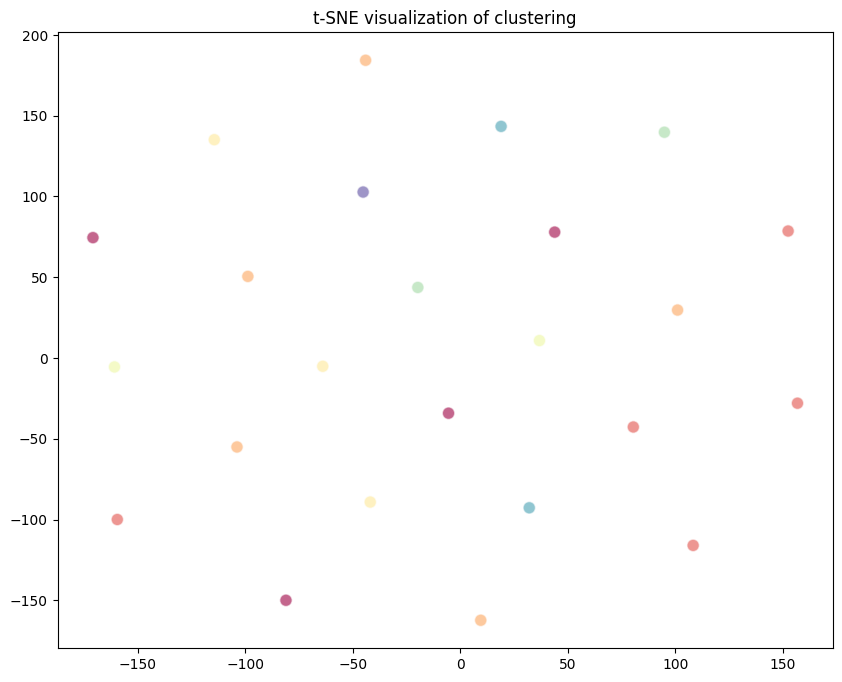

Cluster 0 closest words:
Exclusion

Cluster 1 closest words:
Influence

Cluster 2 closest words:
Exclusion

Cluster 3 closest words:
Neverness

Cluster 4 closest words:
Weakness

Cluster 5 closest words:
Agency

Cluster 6 closest words:
Multiformity

Cluster 7 closest words:
Concurrence

Cluster 0 is best matched with Section/Division 0 with a similarity of 0.0
Cluster 1 is best matched with Section/Division 1 with a similarity of 0.0
Cluster 2 is best matched with Section/Division 2 with a similarity of 0.5
Cluster 3 is best matched with Section/Division 5 with a similarity of 0.25
Cluster 4 is best matched with Section/Division 4 with a similarity of 0.0
Cluster 5 is best matched with Section/Division 6 with a similarity of 0.16666666666666666
Cluster 6 is best matched with Section/Division 3 with a similarity of 0.2
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.20      1.00      0.33         1
      

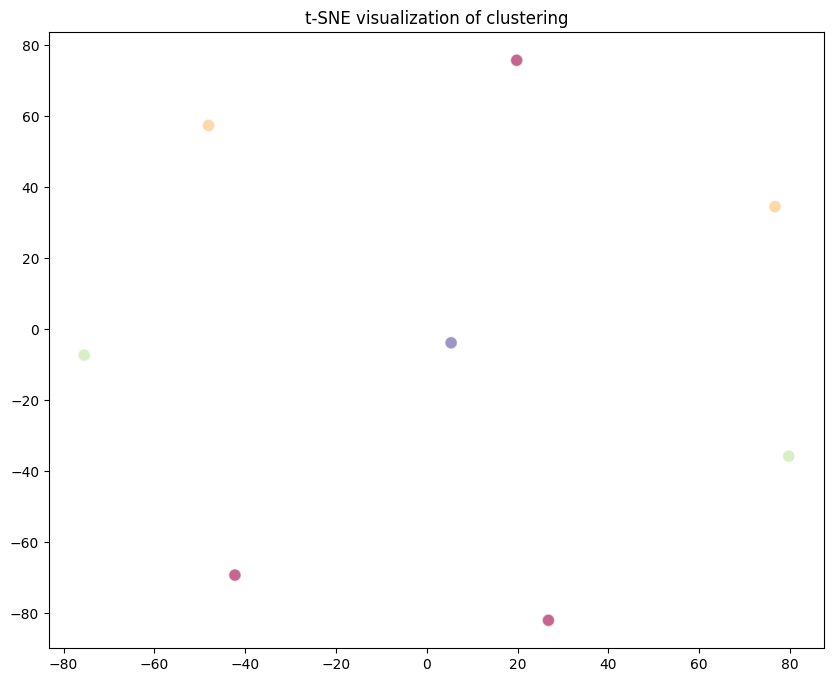

Cluster 0 closest words:
Mariner

Cluster 1 closest words:
Verticality

Cluster 2 closest words:
Plunge

Cluster 3 closest words:
Bluntness

Cluster 0 is best matched with Section/Division 2 with a similarity of 0.3333333333333333
Cluster 1 is best matched with Section/Division 0 with a similarity of 1.0
Cluster 3 is best matched with Section/Division 1 with a similarity of 0.25
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         1
           2       0.60      0.75      0.67         4
           3       0.00      0.00      0.00         3

    accuracy                           0.38         8
   macro avg       0.15      0.19      0.17         8
weighted avg       0.30      0.38      0.33         8


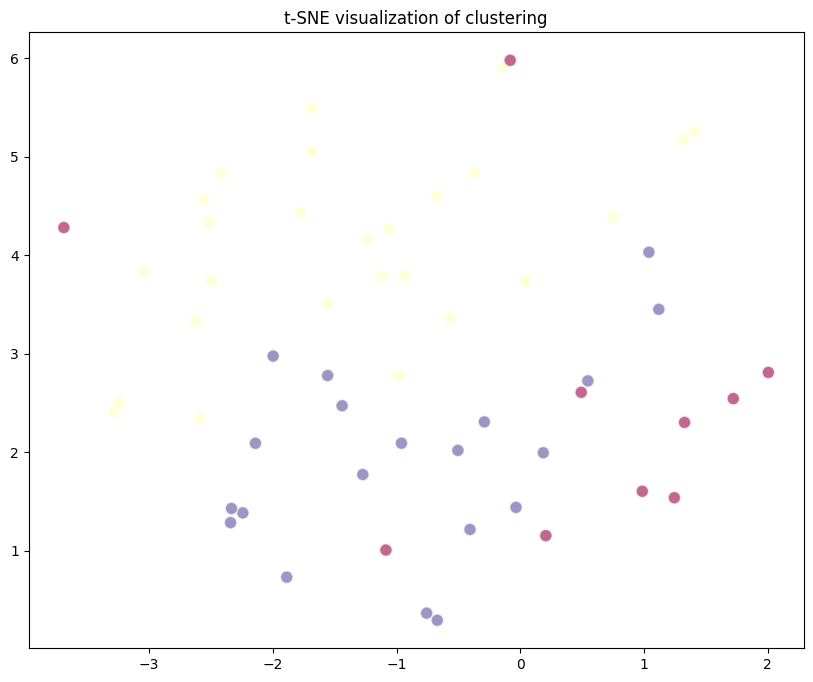

Cluster 0 closest words:
Inelasticity
Calefaction
Sensations of Touch
Botany
Variegation
Wind
Yellowness
Husbandry
Life
Roll

Cluster 1 closest words:
Darkness
Life
Friction
Discord
Resin
Blackness
Island
Fluidity
Roll
Bitterness
Softness
Dryness
Organization
Texture
Appearance
Pulverulence
Elasticity
Vegetability
Gaseity
Yellowness

Cluster 2 closest words:
Fluidity
Dryness
Softness
Vegetability
Loudness
Physical Sensibility
Sensations of Touch
Botany
Blackness
Liquefaction
Darkness
Life
Animal
Hearing
Marsh
Gaseity
Ululation
Concord
Inorganization
Optical Instruments

Cluster 1 is best matched with Section/Division 0 with a similarity of 0.3333333333333333
Cluster 2 is best matched with Section/Division 1 with a similarity of 0.3333333333333333
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.30      0.30      0.30        20
           2       0.00      0.00      0.00        36

    accuracy             

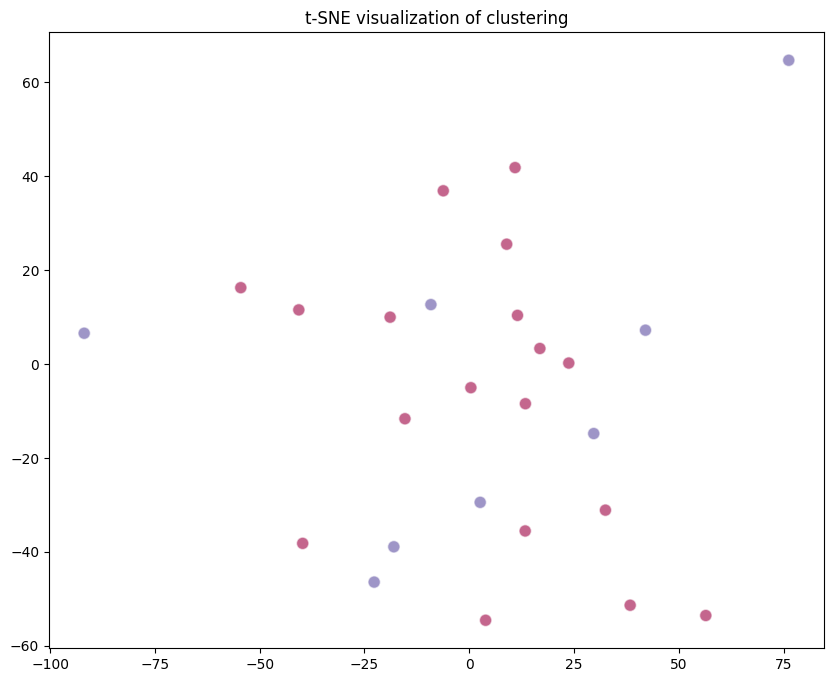

Cluster 0 closest words:
Avoidance

Cluster 1 closest words:
Inaction

Cluster 0 is best matched with Section/Division 0 with a similarity of 0.05555555555555555
Cluster 1 is best matched with Section/Division 1 with a similarity of 0.0
              precision    recall  f1-score   support

           0       0.72      0.72      0.72        18
           1       0.38      0.43      0.40         7
           2       0.00      0.00      0.00         1

    accuracy                           0.62        26
   macro avg       0.37      0.38      0.37        26
weighted avg       0.60      0.62      0.61        26


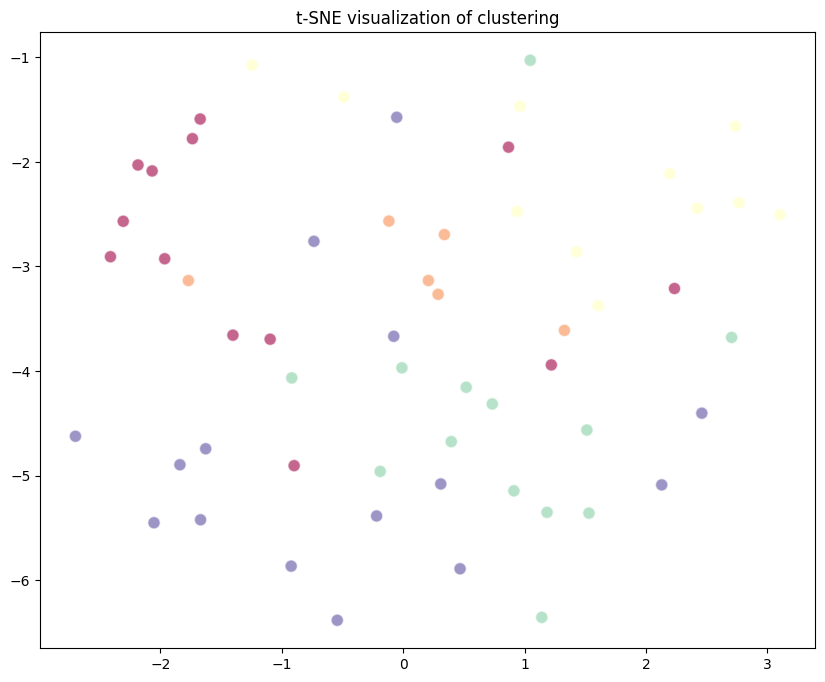

Cluster 0 closest words:
Theology
Sensibility
Vulgarity
Revenge

Cluster 1 closest words:
Expectance
Pride
Punishment
Pity

Cluster 2 closest words:
Insensibility
Painfulness
Ingratitude
Pleasurableness

Cluster 3 closest words:
Accusation
Penalty
Blemish
Exclusion

Cluster 4 closest words:
Caution
Reward
Scourge
Legality

Cluster 0 is best matched with Section/Division 4 with a similarity of 0.125
Cluster 1 is best matched with Section/Division 1 with a similarity of 0.09523809523809523
Cluster 2 is best matched with Section/Division 0 with a similarity of 0.14285714285714285
Cluster 3 is best matched with Section/Division 2 with a similarity of 0.06666666666666667
Cluster 4 is best matched with Section/Division 3 with a similarity of 0.15789473684210525
              precision    recall  f1-score   support

           0       0.27      0.75      0.40         4
           1       0.50      0.16      0.24        19
           2       0.23      0.25      0.24        12
           3     

In [53]:
#initialize i
i = 0

while i <= 5:
    n = counts[i]  # Retrieve the count for the current cluster

    # Fetch the list of words for the current cluster
    words_list = sections_divisions_2.iloc[i]['words']

    # Check if the list of words is empty for the current cluster
    if not words_list:
        print(f"Cluster {i} is empty")  # Notify that the current cluster is empty
        i += 1  # Move to the next cluster
    else:
        # Re-fetch the list of words for the current cluster
        words_list = sections_divisions_2.iloc[i]['words']
    
        # Create a DataFrame from the words list with a single column named 'words'
        words_df = pd.DataFrame(words_list, columns=['words'])
    
        # Apply a function to each word to retrieve its embedding from another DataFrame and convert to a list of lists
        embeddings_list = words_df['words'].apply(
            lambda x: clustering_with_sections_divisions[clustering_with_sections_divisions['words'] == x].iloc[0,
                      :-1].tolist()).tolist()
    
        # Create a DataFrame from the embeddings list
        embeddings_df = pd.DataFrame(embeddings_list)
    
        # Concatenate the words DataFrame with the embeddings DataFrame to prepare for clustering
        words_for_clust_2 = pd.concat([embeddings_df, words_df[['words']]], axis=1)
    
        # Remove unnecessary columns from the DataFrame
        words_for_clust_2 = words_for_clust_2.drop(columns=[768, 769])
        
        # Map each word to its corresponding section/division and add as a new column to the DataFrame
        words_df['sec_div'] = words_df['words'].apply(
            lambda x: true_sec_div[true_sec_div['word'] == x].iloc[0, -1])
    
        # Group words by their section/division and convert into a list of lists
        lists = words_df.groupby('sec_div')['words'].apply(list).reset_index(name='words')
        list_of_lists = lists['words'].tolist()
        
        # Initialize variables to find the minimum and maximum list lengths
        min_length = float('inf')  # Assume the minimum length is infinity initially
        max_length = 0  # Assume the maximum length is 0 initially
        
        # Iterate through each list to find the minimum and maximum lengths
        for sublist in list_of_lists:
            sublist_length = len(sublist)
            if sublist_length < min_length:
                min_length = sublist_length
            if sublist_length > max_length:
                max_length = sublist_length
                
        # Set minimum length to 0 if no lists were found
        if min_length == float('inf'):
            min_length = 0
        
        # Choose KMeansConstrained clustering parameters based on list lengths
        if min_length < n:
            kmeans_constrained = KMeansConstrained(n_clusters=n, size_min=min_length, size_max=max_length, random_state=11234)
        else:
            kmeans_constrained = KMeansConstrained(n_clusters=n, size_min=n-1, size_max=max_length, random_state=11234)
    
        # Fit the KMeansConstrained model to the data
        kmeans_constrained.fit(words_for_clust_2.iloc[:, :-1])
    
        # Retrieve cluster assignments for each word
        cluster_assignments = kmeans_constrained.labels_
    
        # Visualize the clustering result using t-SNE
        visualize_tsne(words_for_clust_2.iloc[:, :-1], cluster_assignments)
    
        # Determine the centroids of each cluster
        centroids = kmeans_constrained.cluster_centers_
    
        # Find the closest points to each centroid
        clusters_words = find_closest_points(words_for_clust_2, centroids, cluster_assignments, top_n=min_length)
    
        # Optimize cluster to class assignments
        label_mapping = match_clusters_to_lists(clusters_words, list_of_lists, "Section/Division")
    
        # Remap cluster labels to match predefined classes
        remapped_labels_constrained = [label_mapping[label] if label in label_mapping else label for label in
                                       cluster_assignments]
    
        # Generate and print a classification report to evaluate clustering performance
        report = classification_report(words_df['sec_div'], remapped_labels_constrained, zero_division=0)
        print(report)
        
        i += 1  # Move to the next cluster
        

***Discussion of the results***
Analyzing the classification reports for the sections/divisions of each class, reveals a wide range of prediction performances, with overall accuracies stretching from a low of 11% to a high of 62%. There is no evidence that the model performs better in the sections or the divisions, because in both cases the accuracy varies. It is logical that we get some low accuracies because we use only the correct words after the remapping of the clusters to the classes, meaning that we use fewer words and that some sections or divisions have zero words because of the low accuracy 27% of the CLASS level clustering. These also confirms that unsupervised learning techniques are not sufficient to achieve Roget Thesarus's classification at a SECTION/DIVISION level, because of the the low accuracy and the complexity of the patterns in the data.
